In [50]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

## Expectation-Maximization Algorithm

The Expectation-Maximization algorithm (EM) seek to find the maximum-likelihood estimator (MLE) of a parameterized model with missing latent values. In particular, consider a probibalistic model where the random variable $X$ is observed, $Z$ is hidden, and $\theta$ is the parameter. Such a model is specified by $p(X,Z|\theta)$, a density when $X$ is continuous. In this case, the MLE is a maximizer of the log likelihood given the observed data (only $Z$ is integrated out),

$$
\max_\theta\mathbb{E}\left[\log p_\theta(X, Z)\,\middle|\,X\right]\,.
$$

Note that usually we have several observations, e.g., $X^{(i)},Z^{(i)}$ for some $i\in[n]$, but the log likelihood of these assumed-independent observations just gets added up we inspect the one-sample case for simplicity.

Many models are easy to specify jointly with latent variables. For example, the Gaussian mixture model with $K$ Gaussian has $Z$ take values in $[K]$ and $\theta$ as the concatenation of the parameters of the $K$ Gaussian parameters $\theta=\left\{\mu_i,\Sigma_i\right\}_{i=1}^K$ and the mixture weights $\pi$. The density of the point $(x,z)$ given a fixed $\theta$ is then just given by the normal PDF, so

$$
\log p_\theta(x, z)= \pi_z\log N(\mu_z,\Sigma_z)(x)\,.
$$

On the other hand, $\mathbb{E}\left[\log p_\theta(X, Z)\,\middle|\,X=x\right]$ is not nearly as pretty. EM transforms this potentially difficult immediate nonconvex optimization problem into usually easier alternating minimization problems. In the case of the Gaussian mixture models, these subproblems are actually convex and, better yet, have a closed-form solution.



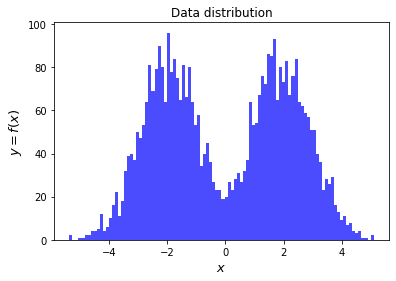

In [89]:
data = np.hstack([np.random.normal(-2, 1, 2000),
                  np.random.normal(2, 1, 2000)])

plt.hist(data, bins=100, color='blue', alpha=0.7)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title('Data distribution')
plt.show()

In [52]:
def expectation_maximization(e, m, X, theta, steps):
    """
    Args:
        inputs X of dimension n
        theta containing pi a k-mixture weight vector, 
        mu a k-mean vector, and sigma a k-standard deviation vector.
    """
    thetas = [theta]
    n = len(X)
    for _ in range(1, steps):
        # Alternating optimization
        Q = e(X, theta)
        theta = m(Q, X)
        thetas.append(theta)
    return thetas

### The EM Algorithm for Discrete Latent Variables
We present the simplified EM algorithm for cases where $Z$ is discrete in $[K]$. Denote by $x_i$ the $i$-th iid observation of $X$, for $i\in[n]$.

We introduce the variable $Q$, an $n\times K$ matrix whose $iz$-th entry $q_{iz}$ will specify $p_\theta(z|x)$ for some fixed $\theta$. Namely, we split the aforementioned likelihood maximization into two steps, assuming some initial solution $Q^{(0)},\theta^{(0)}$. Then for $t>0$ the $t$-th iteration of EM is:

1. (Expectation). Set $q_{iz}^{(t)}=p_{\theta^{(t-1)}}(z|x_i)$
2. (Maximization). Set $\theta^{(t)}=\text{argmax}_\theta\,F(Q,\theta)$, where

$$
F(Q,\theta)=\frac{1}{n}\sum_i\sum_z q_{iz}\log p_\theta(x_i,z)\,.
$$

Since $Z$ is discrete it shouldn't be too hard to compute $p_{\theta^{(t-1)}}(z|x_i)$ with Bayes' rule and $ p_{\theta^{(t-1)}}(x_i,z)$, and the second optimization only relies on ease of optimization of the joint probability with respect to $\theta$. It's clear that EM does something easy in terms of computation, but to see that it's doing anything moderately useful we need to show it's an alternating maximization of the log likelihood $L(\theta)=\frac{1}{n}\sum_i\log \mathbb{E}\left[p_\theta(X, Z)\,\middle|\, X=x_i\right]$.


Indeed, define the function
$$
G(Q, \theta)=F(Q,\theta)-\sum_i \sum_z q_{iz}\log q_{iz}\,,
$$

over pairs where $Q\in \Delta_K^n$ (cartesian product of $n$ $K$-simplices) and $\theta$ is in the parameter space specified by the assumed probibalistic model.

It is possible to show that the EM algorithm is equivalent to the following two steps:

1. $Q^{(t+1)}=\text{argmax}_Q G(Q,\theta^{(t)})$
2. $\theta^{(t+1)}=\text{argmax}_\theta G(Q^{(t+1)},\theta)$

Further, one can show that $G(Q^{(t+1)},\theta^{(t)})=L(\theta)$ (see the reference section 24.4 at the top of this section for details). Then, since alternating maximization results in a non-decreasing sequence of iterates in $G$, the iterates $\theta^{(t)}$ must weakly improve $L$, giving us something with no guarantees but what generally works in practice for finding the MLE.

## Gaussian Mixture Models

In [53]:
def gmm_joint(X, theta):
    """
    returns log p_theta(x_i, z) in the iz-th entry an n x k matrix 
    """
    pi, mu, sigma = theta
    diffs = np.subtract.outer(X, mu) / sigma
    quadratic = -0.5 * diffs ** 2
    normalizing = -0.5 * np.log(2 * np.pi) - np.log(sigma)
    logpx_given_z = quadratic + normalizing
    # want p_\theta(z) * p_\theta(x|z) = p_\theta(x, z)
    return logpx_given_z  + np.log(pi)


def gmm_expectation(X, theta):
    joint = gmm_joint(X, theta)
    
    # p_\theta(z|x) = p_\theta(x, z) / p_\theta(x)
    pz_given_x = np.exp(
        joint - logsumexp(joint, axis=1, keepdims=True))
    return pz_given_x


def gmm_maximization(Q, X):
    mixture_weight_sums = Q.sum(axis=0)
    pi = mixture_weight_sums / mixture_weight_sums.sum()
    mu = Q.T.dot(X) / mixture_weight_sums
    diffs = np.subtract.outer(X, mu)
    diffs *= Q
    sigma = np.sum(diffs ** 2, axis=0)
    sigma /= mixture_weight_sums
    return pi, mu, np.sqrt(sigma)


def gmm_likelihood(X, theta):
    joint = gmm_joint(X, theta)
    # want p_\theta(x) = sum_z p_\theta(x, z)
    # then also sum over xs for likelihood of all data
    return logsumexp(joint)

# Define the Gaussian mixture models optimization
gmm = partial(expectation_maximization, e=gmm_expectation, m=gmm_maximization)

Importance of initialization of the means of GMM.

K-means can be used for initialization.

In [99]:
# Initialize the parameters
pi_1 = 0.5
theta = (
    [pi_1, 1 - pi_1], # mixture weights
    np.percentile(data, [25, 75]), # mean
    np.random.uniform(0.5, 2, size=2)) # standard deviation

thetas = gmm(X=data, theta=theta, steps=20)

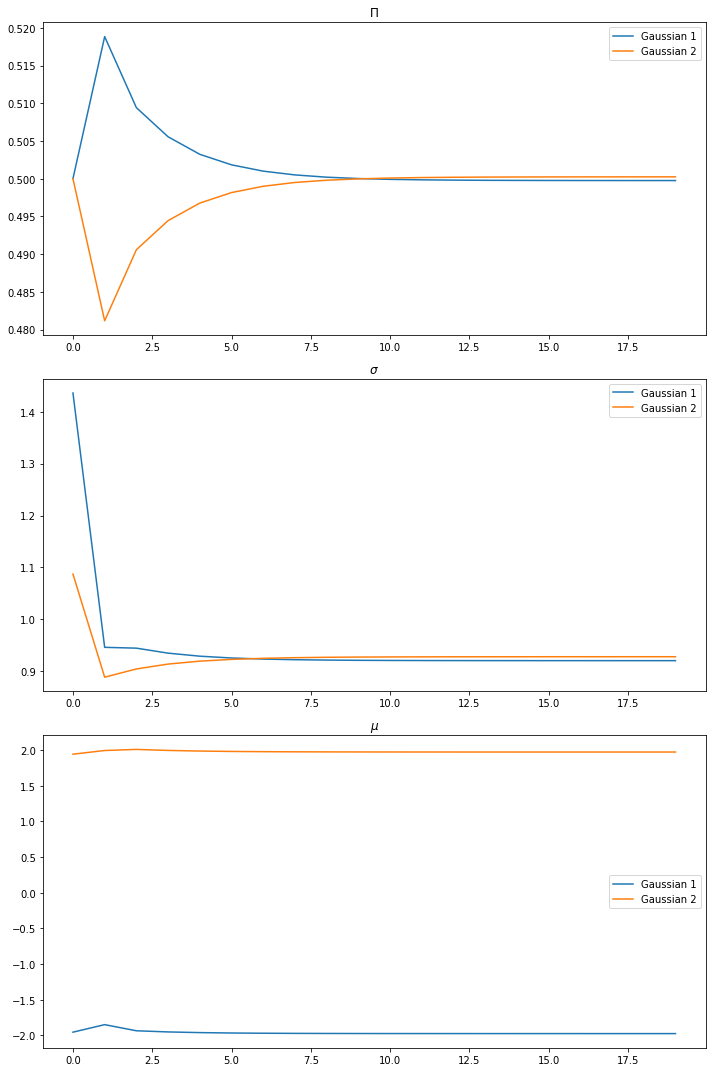

In [100]:
def visualize_parameters(thetas, num_gauss): 
    thetas = np.array(
        thetas, 
        dtype=[('pi', float, (num_gauss,)), ('mu', float, (num_gauss,)), ('std', float, (num_gauss,))]
    )

    # Extract pi, mu, std data
    pi_values = thetas['pi']
    mu_values = thetas['mu']
    std_values = thetas['std']

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    x_test_data = np.arange(0, pi_values.shape[0])

    # Plotting Pi values
    for i in range(num_gauss):
        axs[0].plot(x_test_data, pi_values[:, i], label=f'Gaussian {i+1}')
    axs[0].set_title('$\Pi$')
    axs[0].legend()

    # Plot Sigma values
    for i in range(num_gauss):
        axs[1].plot(x_test_data, std_values[:, i], label=f'Gaussian {i+1}')
    axs[1].set_title('$\sigma$')
    axs[1].legend()

    # Plot Mu values
    for i in range(num_gauss):
        axs[2].plot(x_test_data, mu_values[:, i], label=f'Gaussian {i+1}')
    axs[2].set_title('$\mu$')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

visualize_parameters(thetas, num_gauss=2)

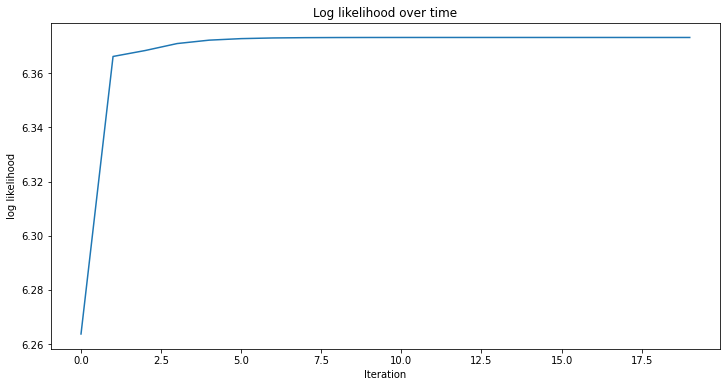

In [76]:
# Visualize the likelihood over time
def plot_likelihood(data, thetas):

    plt.figure(figsize=(12, 6))
    likelihoods = [gmm_likelihood(data, t) for t in thetas]
    plt.plot(likelihoods)
    plt.title("Log likelihood over time")
    plt.xlabel('Iteration')
    plt.ylabel('log likelihood')
    plt.show()

plot_likelihood(data, thetas)

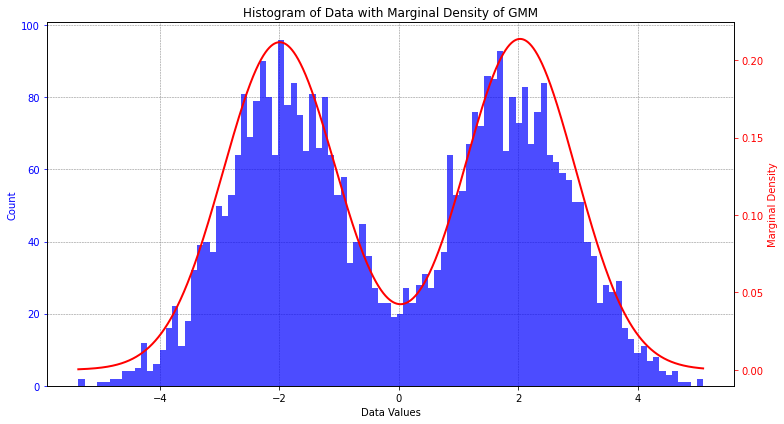

In [93]:
def plot_fit(data, thetas):
    fig, ax1 = plt.subplots(figsize=(11, 6))

    # Histogram
    n, bins, patches = ax1.hist(data, bins=100, color='blue', alpha=0.7)
    ax1.set_ylabel('Count', color='b')
    ax1.tick_params(axis='y', colors='b')
    ax1.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    ax1.set_axisbelow(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Marginal Density', color='r')
    ax2.tick_params('y', colors='r')
    xs = np.linspace(data.min(), data.max(), 10000)
    ax2.plot(xs, np.sum(np.exp(gmm_joint(xs, thetas[-1])), axis=1), color='red', linewidth=2)

    ax1.set_xlabel('Data Values')
    ax1.set_title('Histogram of Data with Marginal Density of GMM')
    fig.tight_layout()
    plt.show()

plot_fit(data, thetas)

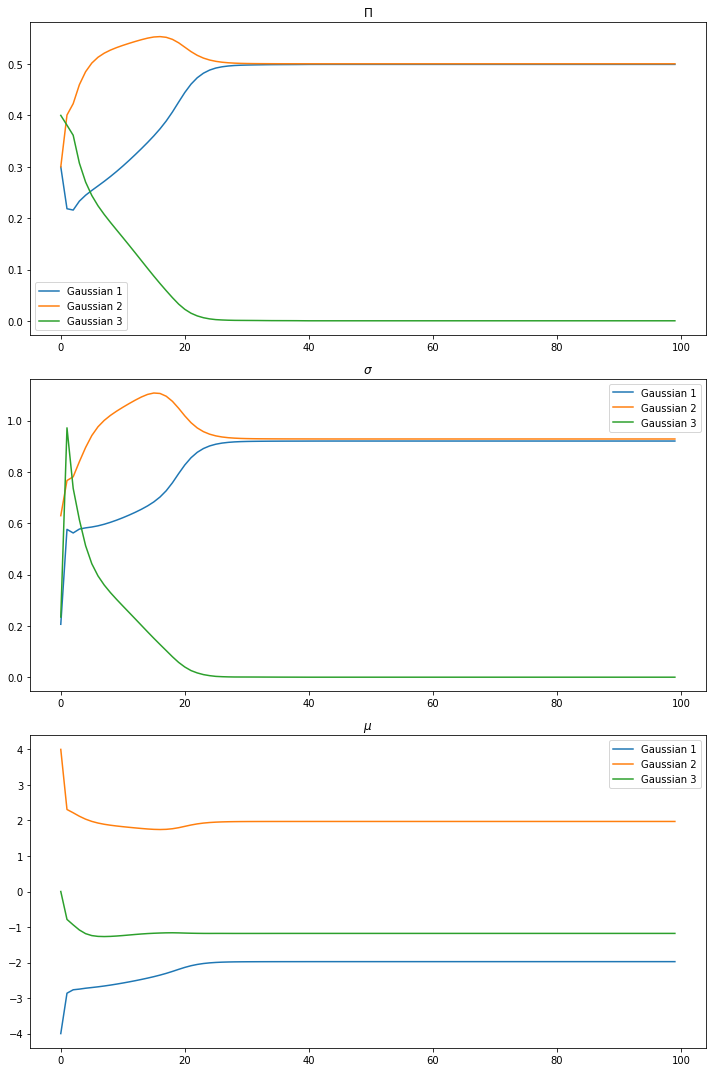

In [141]:
# Initialize the parameters
theta = (
    [3/10, 3/10, 4/10], # mixture weights
    [-4, 4, 0], # mean
    np.random.uniform(0.2, 1, size=3)) # standard deviation

thetas = gmm(X=data, theta=theta, steps=100)
visualize_parameters(thetas, num_gauss=3)

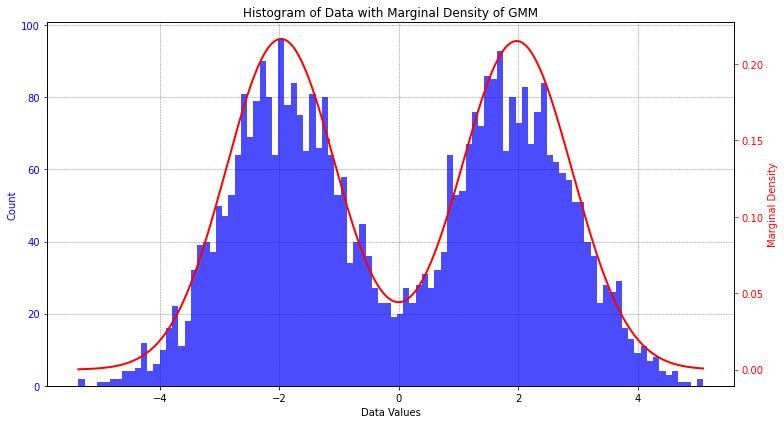

In [142]:
plot_fit(data, thetas)